# LIBRARIES

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import imageio
import plotly.express as px
from tqdm import tqdm

from sklearn.manifold import TSNE
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA

import optuna
from optuna.samplers import TPESampler, RandomSampler

from torchbearer.callbacks import Best

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision
from torchvision import transforms

In [2]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f"Training device: {device}")

Training device: cuda


# DATASET

The dataset used in this homework is the FashionMNIST. It is composed by a training and a test set, the first one composed by 6000 elements, the second one by 1000. Each element consists in a couple of piece of cloth image 28X28 with only one color channel, and the corresponding label. 

In [2]:
poss_labels=["T-shirt/top","Trouser","Pullover","Dress","Coat","Sandal","Shirt","Sneaker","Bag","Ankle boot"]

Some transformations are applied to the samples. In particular both the images and the labels are converted into torch tensors, and the values of the images bits are multiplied by 255 in order to switch from the range [0,1] given by default by the command by torch to import the dataset, to the range [0,255]. This choice generally leads to better results.

In [3]:
composed_transform = transforms.Compose([transforms.ToTensor(), 
                                         #transforms.Normalize(0,50)])
                                         transforms.Lambda(lambda x: x*255)])

target_composed_transform = transforms.Compose([transforms.ToTensor(), 
                                                #transforms.Normalize(0,50)])
                                                transforms.Lambda(lambda x: x*255)])

In [ ]:
train_mnist = torchvision.datasets.FashionMNIST('classifier_data', train=True, download=True, 
                                                transform=composed_transform
                                                )
test_dataset  = torchvision.datasets.FashionMNIST('classifier_data', train=False, download=True,
                                                 transform=target_composed_transform
                                                 )

The training test is then divided in training and validation set, with a ratio of 0.9, in order to evaluate the performance of the algorithms to be implemented on a bunch of samples which not contribute to the training.

In [6]:
np.random.seed(0)
torch.manual_seed(10)

train_dim=int(len(train_mnist)*0.9)
val_dim=int(len(train_mnist)-train_dim)

train_dataset, val_dataset = random_split(train_mnist, [train_dim, val_dim])

The training dataloader batch size is chosen to be 500 in order to have a mini-batch dimension high enough for the set to be representative of the whole dataset, but at the same time is enough small to allow some degree of stochasticity in the weights update optimization procedure. The validation dataloader batch size is of the same dimension of the dataset because the only goal of evaluating the net on this set is to get an idea about the performance of the algorithm.

In [7]:
train_dataloader = DataLoader(train_dataset, batch_size=500, shuffle=True, num_workers=0)
val_dataloader = DataLoader(val_dataset, batch_size=len(val_dataset), shuffle=False, num_workers=0)
test_dataloader = DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=False, num_workers=0)

print(f"Training dataset dimension: {len(train_dataloader.dataset)}")
print(f"Validation dataset dimension: {len(val_dataloader.dataset)}")
print(f"Test dataset dimension: {len(test_dataloader.dataset)}")

Training dataset dimension: 54000
Validation dataset dimension: 6000
Test dataset dimension: 10000


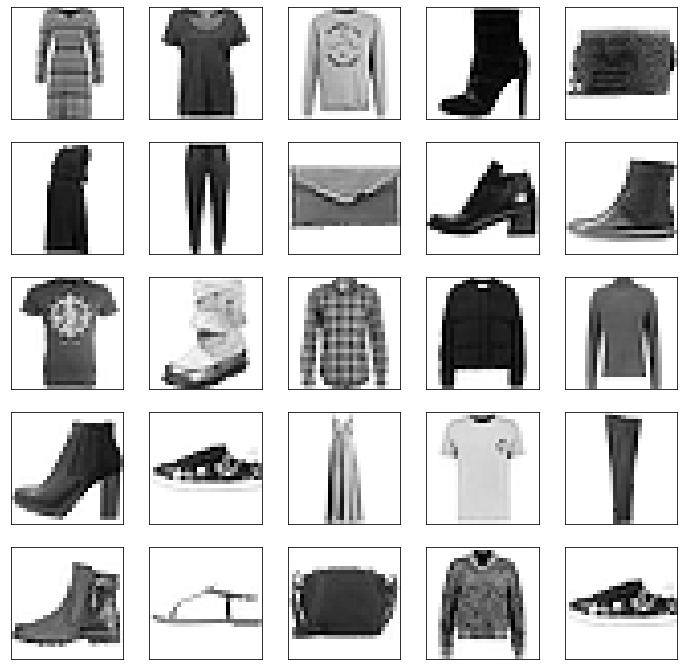

In [8]:
np.random.seed(0)
torch.manual_seed(10)

sample_index = np.random.randint(0,1000,25)
__, ax = plt.subplots(5,5,figsize=(12,12))

for i,axi in enumerate(ax.flatten()):
    image = train_dataset[sample_index[i]][0][0]
    axi.imshow(image, cmap="Greys")
    axi.set_xticks([])
    axi.set_yticks([])

# AUTOENCODER

The first task of the work is to build an autoencoder. An autoencoder consist in a neural network composed by two essential blocks. A Encoder, which reduce the dimensionality of the input into a few latent variables, and a Decoder, which takes this latent variable and tries to reconstruct the input. The loss for this architecture is given by a difference between the input and the output of the net, usually performed by the MSE function, because the goal is to produce an output as similar as possible to the original input.

## Network

Given the fact that the dataset used in this task is composed by images, the most natural typology of network to choose in a convolutional one. In particular the encoder is composed by Conv2d layers and BatchNorm2d for the normalization of the weights during the training, but, differently from a network for a classification task,no dropout layers are used, because, for the image reconstruction task we want to perform, the focus is to be as precise as possible, and there is no interest in increasing the generality by not relying too much on a single neuron.
The Decoder is build in order to be as symmetric as possible with respect to the encoder. This choice is not mandatory but quite reasonable for the structure of the problem. In order to do so the ConvTranspose2d layers are used. These acts in the reverse way of a convolutional layer, with the final result to enlarge the image give in in input.


In [9]:
# custom weights initialization called on netG and netD
def weights_init_xavier_normal(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.xavier_normal_(m.weight.data)
    elif classname.find('Linear') != -1:
        nn.init.xavier_normal_(m.weight.data)
        nn.init.constant_(m.bias.data, 0)
    elif classname.find('BatchNorm') != -1:
        nn.init.constant_(m.weight.data, 1)

In [10]:
class Autoencoder(nn.Module):
    
    def __init__(self, latent_dim=20, nonlin=nn.ReLU()):
        """
        N - vector with layer dimensions
        """
        super().__init__()

        self.latent_dim = latent_dim

        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=5, kernel_size=(4,4),stride=2),
            nn.BatchNorm2d(num_features=5),
            nonlin,
            nn.Conv2d(in_channels=5, out_channels=10, kernel_size=(3,3),stride=2),
            nn.BatchNorm2d(num_features=10),
            nonlin,
            nn.Flatten(),
            nn.Linear(in_features=360, out_features=self.latent_dim)
        )

        self.decoder = nn.Sequential(
            nn.Linear(in_features=self.latent_dim, out_features=360),
            nonlin,
            nn.Unflatten(dim=1, unflattened_size=(10,6,6)),
            nn.ConvTranspose2d(in_channels=10, out_channels=5, kernel_size=(3,3), stride=2),
            nonlin, 
            nn.ConvTranspose2d(in_channels=5, out_channels=1, kernel_size=(4,4), stride=2)
        )

    
    def forward(self, x):
        z = self.encoder(x)
        x_out = self.decoder(z)
        return x_out

The pytorch Autoencoder module is composed by two main attributes, the encoder and the decoder. In this way it is possible to separately generate the latent variables and to decode them by reconstruction an image.

In [11]:
print(Autoencoder())

Autoencoder(
  (encoder): Sequential(
    (0): Conv2d(1, 5, kernel_size=(4, 4), stride=(2, 2))
    (1): BatchNorm2d(5, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(5, 10, kernel_size=(3, 3), stride=(2, 2))
    (4): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=360, out_features=20, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=20, out_features=360, bias=True)
    (1): ReLU()
    (2): Unflatten(dim=1, unflattened_size=(10, 6, 6))
    (3): ConvTranspose2d(10, 5, kernel_size=(3, 3), stride=(2, 2))
    (4): ReLU()
    (5): ConvTranspose2d(5, 1, kernel_size=(4, 4), stride=(2, 2))
  )
)


## Training

In [12]:
def train_epoch(model, dataloader, optimizer, loss_fn):
    model.train()
    train_loss=[]
    for sample_batched in dataloader:
        x_batch = sample_batched[0].to(device)
        out=model(x_batch)
        # Compute loss
        loss = loss_fn(x_batch, out)
        # Save train loss for this batch
        loss_batch = loss.detach().cpu().numpy()

        # Backpropagation
        model.zero_grad()
        loss.backward()

        # Update the weights
        optimizer.step()

        # Save train loss for this batch
        train_loss.append(loss_batch)

    # Save average train loss
    return np.mean(train_loss)

In [13]:
def val_epoch(model, dataloader, loss_fn):
    model.eval()
    val_loss=[]
    for sample_batched in dataloader:
        x_batch = sample_batched[0].to(device)
        out=model(x_batch)
        # Compute loss
        loss = loss_fn(x_batch, out)
        # Save train loss for this batch
        loss_batch = loss.detach().cpu().numpy()
        val_loss.append(loss_batch)

    # Save average train loss
    return np.mean(val_loss)

In [14]:
def AEtraining(num_epochs, latent_dim, ae_loss, optim_name, lr=1e-2, w_d=0, momentum=0.9, nonlin="relu", checkpoint="", weights_init=None, printt=False):

    train_loss_log=[]
    val_loss_log=[]

    if nonlin=="ReLU" or nonlin=="relu":
        nonlin=nn.ReLU()
    elif nonlin=="Sigmoid" or nonlin=="sigmoid":
        nonlin=nn.Sigmoid()
    elif nonlin=="Tanh" or nonlin=="tanh":
        nonlin=nn.Tanh()

    myAutoenc = Autoencoder(latent_dim, nonlin)
    myAutoenc.to(device)

    if checkpoint!="":
        myAutoenc.load_state_dict(torch.load(checkpoint))
    elif weights_init!=None:
        myAutoenc.apply(weights_init)

    if optim_name=="Adam" or optim_name=="adam":
        optimizer=optim.Adam(myAutoenc.parameters(), lr=lr, weight_decay=w_d)
    elif optim_name=="SGD" or optim_name=="sgd":
        optimizer=optim.SGD(myAutoenc.parameters(), lr=lr, momentum=momentum)
    else:
        optimizer=optim.Adam(myAutoenc.parameters(), lr=1e-2)

    for epoch in tqdm(range(num_epochs)):
        
        train_loss = train_epoch(myAutoenc, train_dataloader, optimizer, ae_loss)
        train_loss_log.append(train_loss)
        val_loss = val_epoch(myAutoenc, val_dataloader, ae_loss)
        val_loss_log.append(val_loss)

        if printt: print(f'Train loss: {train_loss}')
        if printt: print(f'Valid loss: {val_loss}')
        
    return myAutoenc, train_loss_log, val_loss_log

In [15]:
np.random.seed(0)
torch.manual_seed(10)

myAutoenc, train_loss_log, val_loss_log = AEtraining(num_epochs=70,
                                                     latent_dim=20, 
                                                     ae_loss=nn.MSELoss(),
                                                     optim_name="SGD",
                                                     lr=5e-5,
                                                     w_d=2e-4,
                                                     nonlin="relu",
                                                     #checkpoint="finetuned_Autoenc.pth",
                                                     printt=False
                                                     )

100%|██████████| 70/70 [04:58<00:00,  4.27s/it]


## Loss

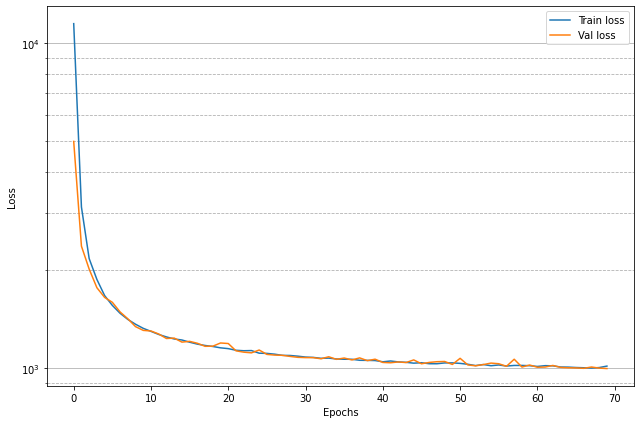

In [16]:
plt.figure(figsize=(9,6))
plt.semilogy(train_loss_log, label='Train loss')
plt.semilogy(val_loss_log, label='Val loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid(axis="y", which="minor", linestyle="--")
plt.grid(axis="y", which="major")
plt.tight_layout()

## Results

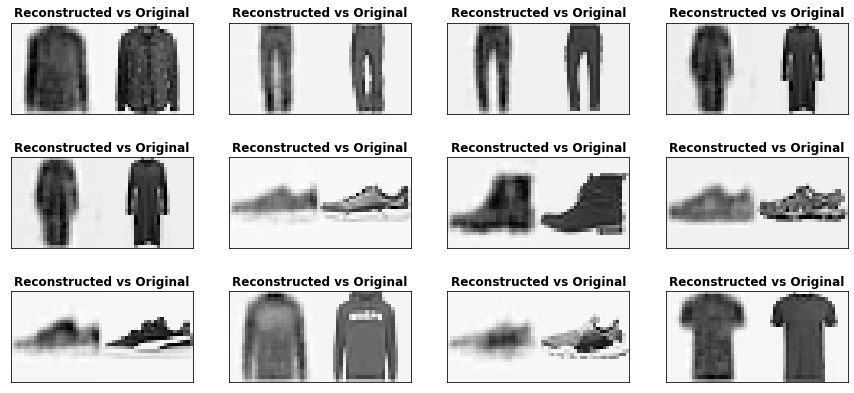

In [17]:
np.random.seed(0)
torch.manual_seed(10)

nsample=np.random.randint(0,100,12)

__, ax = plt.subplots(nrows=3,ncols=4, figsize=(15,7))
with torch.no_grad():
    for i in range(3):
        for j in range(4):
            inp=torch.reshape(test_dataset[nsample[4*i+j]][0],(1,1,28,28)).to(device)

            ax[i,j].imshow(np.hstack((myAutoenc(inp)[0][0].detach().cpu(), inp[0][0].detach().cpu())), cmap="Greys")
            ax[i,j].set_title("Reconstructed vs Original", fontweight="bold")

    [axi.set_xticks([]) for axi in ax.flatten()]
    [axi.set_yticks([]) for axi in ax.flatten()]

plt.show()

In [18]:
torch.save(myAutoenc.state_dict(), 'finetuned_Autoenc.pth')

## Optimization OPTUNA

In [19]:
np.random.seed(0)
torch.manual_seed(10)

def objective(trial):

    # We optimize the number of hidden units in each layer.
    hyperparameters = [
        trial.suggest_int("latent_dim", 5,30),
        trial.suggest_categorical("optimizer", ["Adam", "SGD"]),
        trial.suggest_float("lr", 1e-5, 1e-2, log=True),
        trial.suggest_float("w_d", 1e-6, 1e-2, log=True),
        trial.suggest_categorical("weights_init", [None, "xavier_normal"])
    ]

    if hyperparameters[4]=="xavier_normal":
        hyperparameters[4]=weights_init_xavier_normal

    myAutoenc_opt, train_loss_log_opt, val_loss_log_opt = AEtraining(num_epochs=30,
                                                        latent_dim=hyperparameters[0],
                                                        ae_loss=nn.MSELoss(),
                                                        optim_name=hyperparameters[1],
                                                        lr=hyperparameters[2],
                                                        w_d=hyperparameters[3],
                                                        nonlin="relu",
                                                        weights_init=hyperparameters[4])


    return val_loss_log_opt[-1]

pruner: optuna.pruners.BasePruner = optuna.pruners.NopPruner()
sampler = RandomSampler(seed=100)
study = optuna.create_study(study_name="Autoencoder optimization", direction="minimize", pruner=pruner, sampler=sampler)
study.optimize(objective, n_trials=30)

print("Number of finished trials: {}".format(len(study.trials)))

print("Best trial:")
trial = study.best_trial

print("  Validation loss: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2022-01-18 23:07:44,024] A new study created in memory with name: Autoencoder optimization
100%|██████████| 30/30 [02:11<00:00,  4.38s/it]
[W 2022-01-18 23:09:55,480] Trial 0 failed, because the objective function returned nan.
100%|██████████| 30/30 [02:11<00:00,  4.39s/it]
[I 2022-01-18 23:12:07,275] Trial 1 finished with value: 8134.447265625 and parameters: {'latent_dim': 26, 'optimizer': 'SGD', 'lr': 0.004720259369179813, 'w_d': 6.867655291394635e-06, 'weights_init': None}. Best is trial 1 with value: 8134.447265625.
100%|██████████| 30/30 [02:12<00:00,  4.41s/it]
[I 2022-01-18 23:14:19,681] Trial 2 finished with value: 4679.5966796875 and parameters: {'latent_dim': 10, 'optimizer': 'Adam', 'lr': 3.279616314860827e-05, 'w_d': 0.0018403439376954173, 'weights_init': 'xavier_normal'}. Best is trial 2 with value: 4679.5966796875.
100%|██████████| 30/30 [02:12<00:00,  4.41s/it]
[I 2022-01-18 23:16:31,967] Trial 3 finished with value: 4536.02734375 and parameters: {'latent_dim': 29, 

Number of finished trials: 30
Best trial:
  Validation loss: 946.533203125
  Params: 
    latent_dim: 28
    optimizer: Adam
    lr: 0.00469502418976405
    w_d: 0.00020305140438909737
    weights_init: None


## Latent space

In [20]:
np.random.seed(0)
torch.manual_seed(10)

nsamples=len(test_dataset)
myAutoenc.eval()
labels = test_dataset.targets

z_vec = []

for i in range(nsamples):
    inp=torch.reshape(test_dataset[i][0],(1,1,28,28)).to(device)
    with torch.no_grad():
        z = myAutoenc.encoder(inp)
    z_vec.append(z.detach().cpu().numpy())

z_vec = np.array(z_vec)[:,0,:]

### TSNE

In [21]:
np.random.seed(0)
torch.manual_seed(10)

z_embedded = TSNE(n_components=2, init="pca", learning_rate="auto").fit_transform(z_vec)

df = pd.DataFrame(z_embedded)
df['label'] = labels.long()
df['label_name'] = df.label.apply(lambda l: poss_labels[l])

px.scatter(df, x=0, y=1, color="label_name", width=800, height=600)

### PCA

In [22]:
pca = PCA(2)
z_pca = pca.fit_transform(z_vec)

df_pca = pd.DataFrame(z_pca)
df_pca['label'] = labels.long()
df_pca['label_name'] = df_pca.label.apply(lambda l: poss_labels[l])

px.scatter(df_pca, x=0, y=1, color="label_name", width=800, height=600)

## Generation of new samples

In [23]:
minAE_z = np.min(z_vec,axis=0)
maxAE_z = np.max(z_vec,axis=0)

min_maxAE_df = pd.DataFrame({"min":minAE_z, "max":maxAE_z})

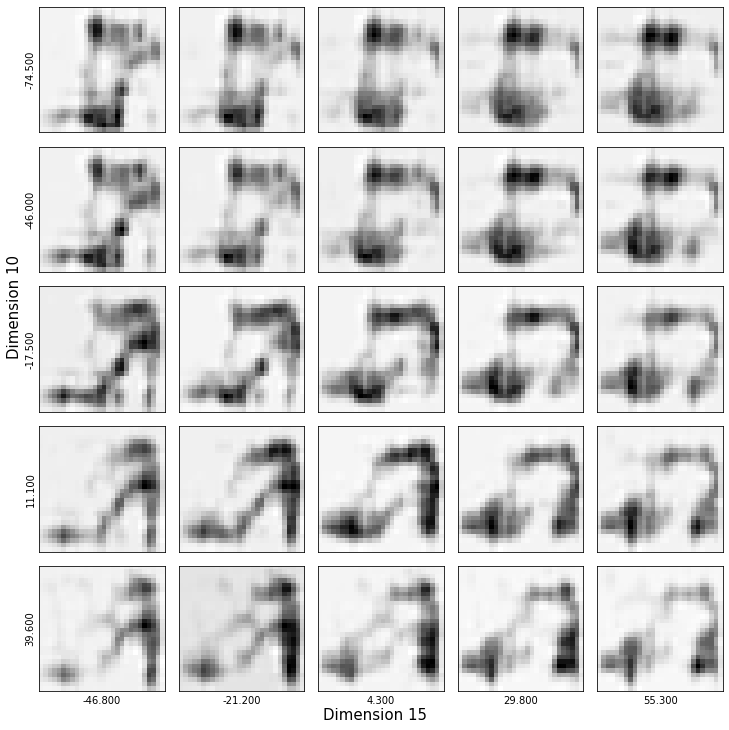

In [24]:
np.random.seed(10)

index=np.random.randint(len(test_dataset))
inp=torch.reshape(test_dataset[index][0],(1,1,28,28)).to(device)
new_z = myAutoenc.encoder(inp)
dim_lat1 = 15
dim_lat2 = 10
range1 = np.round(np.linspace(min_maxAE_df.iloc[dim_lat1]["min"]-5,min_maxAE_df.iloc[dim_lat1]["max"]+5,5),1)
range2 = np.round(np.linspace(min_maxAE_df.iloc[dim_lat2]["min"]-10,min_maxAE_df.iloc[dim_lat2]["max"]+10,5),1)


__, ax = plt.subplots(5,5,figsize=(10,10))
#ax=ax.flatten()
for i in range(5):
    new_z[0,dim_lat1]=range1[i]
    for j in range(5):
        new_z[0,dim_lat2]=range2[j]
        with torch.no_grad():
            new_samp = myAutoenc.decoder(new_z)
        #ax[i][j].set_title(f"Dim1: {range1[i]}, Dim2:{range2[j]}")
        ax[i][j].imshow(new_samp.detach().cpu().numpy()[0,0,:,:], cmap="Greys")
        ax[i][j].set_xticks([])
        ax[i][j].set_yticks([])

[ax[j][0].set_ylabel("%.3f" %(range1[j])) for j in range(5)]
[ax[-1][j].set_xlabel("%.3f" %(range2[j])) for j in range(5)]
__.text(0.5, -0.005, f"Dimension {dim_lat1}", ha='center', fontsize=15)
__.text(0, 0.5, f"Dimension {dim_lat2}", ha='center', fontsize=15, rotation=90)

plt.tight_layout()
plt.show()

## 2-D latent space

### Training

In [25]:
np.random.seed(0)
torch.manual_seed(10)

myAutoenc_2D, train_loss_log_2D, val_loss_log_2D = AEtraining(num_epochs=50,
                                                     latent_dim=2, 
                                                     ae_loss=nn.MSELoss(),
                                                     optim_name="Adam",
                                                     lr=1e-2,
                                                     w_d=0,
                                                     nonlin="relu",
                                                     #checkpoint="finetuned_Autoenc2D.pth"
                                                     )

100%|██████████| 50/50 [03:38<00:00,  4.37s/it]


In [26]:
torch.save(myAutoenc_2D.state_dict(), "finetuned_Autoenc2D.pth")

### Latent space

In [27]:
nsamples=len(test_dataset)
labels = test_dataset.targets

myAutoenc_2D.eval()

z_vec_2D = []

for i in range(nsamples):
    inp=torch.reshape(test_dataset[i][0],(1,1,28,28)).to(device)
    with torch.no_grad():
        z = myAutoenc_2D.encoder(inp)
    z_vec_2D.append(z.detach().cpu().numpy())

z_vec_2D = np.array(z_vec_2D)[:,0,:]

In [28]:
df_2D = pd.DataFrame(z_vec_2D)
df_2D['label'] = labels.long()
df_2D['label_name'] = df_2D.label.apply(lambda l: poss_labels[l])

px.scatter(df_2D, x=0, y=1, color="label_name", width=800, height=600)

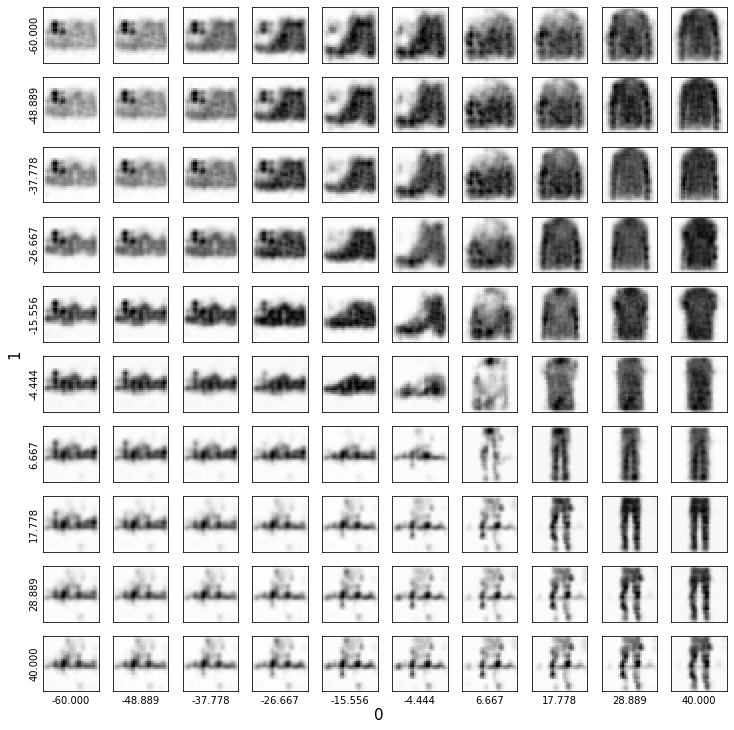

In [29]:
x_AE_1=np.linspace(-60,40,10)
x_AE_2=np.linspace(-60,40,10)


__, ax_AE_2D=plt.subplots(len(x_AE_1),len(x_AE_2),figsize=(10,10))
for i,x1 in enumerate(x_AE_1):
    for j,x2 in enumerate(x_AE_2):
        new_z_2D=torch.Tensor([x1,x2]).unsqueeze(0).to(device)
        ax_AE_2D[i,j].imshow(myAutoenc_2D.decoder(new_z_2D).detach().cpu().numpy()[0,0], cmap="Greys")
[axx.set_xticks([]) for axx in ax_AE_2D.flatten()]
[axx.set_yticks([]) for axx in ax_AE_2D.flatten()]

[ax_AE_2D[j][0].set_ylabel("%.3f" %(x_AE_1[j])) for j in range(len(x_AE_1))]
[ax_AE_2D[-1][j].set_xlabel("%.3f" %(x_AE_2[j])) for j in range(len(x_AE_2))]

__.text(0.5, -0.005, '0', ha='center', fontsize=15)
__.text(-0.005, 0.5, '1', ha='center', fontsize=15, rotation=90)

plt.tight_layout()
plt.show()

# FINE-TUNED AUTOENCODER for classification

### Definition

In [30]:
#load good state of the autoencoder trained before
myAutoenc=Autoencoder().to(device)
myAutoenc.load_state_dict(torch.load("finetuned_Autoenc.pth"))

<All keys matched successfully>

In [31]:
for param_name, param in myAutoenc.encoder.named_parameters():
    param.requires_grad = False  

In [32]:
Aut_FT=nn.Sequential(myAutoenc.encoder,
                     nn.BatchNorm1d(myAutoenc.latent_dim),
                     nn.Linear(myAutoenc.latent_dim,128),
                     nn.ReLU(),
                     nn.Linear(128, 10)).to(device)

print(Aut_FT)

Sequential(
  (0): Sequential(
    (0): Conv2d(1, 5, kernel_size=(4, 4), stride=(2, 2))
    (1): BatchNorm2d(5, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(5, 10, kernel_size=(3, 3), stride=(2, 2))
    (4): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=360, out_features=20, bias=True)
  )
  (1): BatchNorm1d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): Linear(in_features=20, out_features=128, bias=True)
  (3): ReLU()
  (4): Linear(in_features=128, out_features=10, bias=True)
)


In [33]:
# Check if correct
for param_name, param in Aut_FT.named_parameters():
    print('%s \t- requires_grad=%s' % (param_name, param.requires_grad))

0.0.weight 	- requires_grad=False
0.0.bias 	- requires_grad=False
0.1.weight 	- requires_grad=False
0.1.bias 	- requires_grad=False
0.3.weight 	- requires_grad=False
0.3.bias 	- requires_grad=False
0.4.weight 	- requires_grad=False
0.4.bias 	- requires_grad=False
0.7.weight 	- requires_grad=False
0.7.bias 	- requires_grad=False
1.weight 	- requires_grad=True
1.bias 	- requires_grad=True
2.weight 	- requires_grad=True
2.bias 	- requires_grad=True
4.weight 	- requires_grad=True
4.bias 	- requires_grad=True


### Training

In [34]:
np.random.seed(0)
torch.manual_seed(10)

from torchbearer import Trial
checkpoint = Best('Aut_FT.pth', monitor='val_acc', mode='max')

trial = Trial(Aut_FT, 
              optim.Adam(Aut_FT.parameters(), lr=5e-04), 
              nn.CrossEntropyLoss(), 
              metrics=["loss", "acc"], 
              callbacks=[checkpoint]).cuda()

trial.with_generators(train_generator=train_dataloader, val_generator=val_dataloader, test_generator=test_dataloader)

mytrial = trial.run(epochs=50, verbose=1)

  0%|          | 0/50 [00:00<?, ?it/s]

### Results

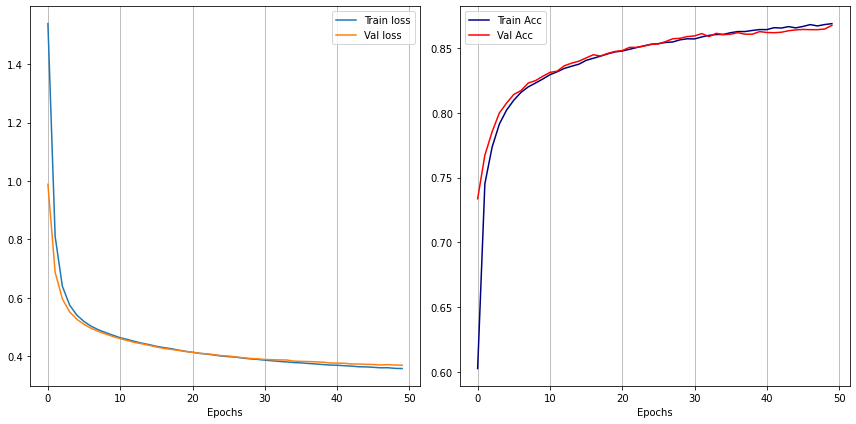

In [35]:
__, ax = plt.subplots(1,2,figsize=(12,6))

ax[0].plot([mt["loss"] for mt in mytrial], label="Train loss")
ax[0].plot([mt["val_loss"] for mt in mytrial], label="Val loss")

ax[1].plot([mt["acc"] for mt in mytrial], label="Train Acc", color="navy")
ax[1].plot([mt["val_acc"] for mt in mytrial], label="Val Acc", color="red")

[axi.set_xlabel("Epochs") for axi in ax]
[axi.legend() for axi in ax]
[axi.grid(axis="x") for axi in ax]

plt.tight_layout()

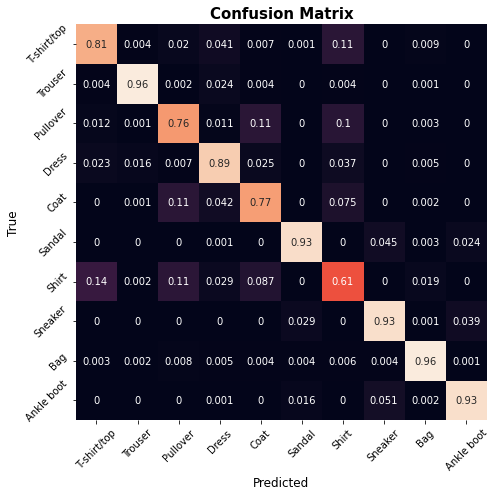

Prediction accuracy: 0.8557


In [36]:
np.random.seed(0)
torch.manual_seed(10)

ffig, axheat = plt.subplots(ncols=1, nrows=1, figsize=(7,7))
Aut_FT.eval()
with torch.no_grad():
    pred_val = Aut_FT(next(iter(test_dataloader))[0].to(device)).argmax(axis=1).cpu().numpy()

labels = test_dataset.targets.numpy()

sns.heatmap(confusion_matrix(labels, pred_val, normalize="true"), ax=axheat, annot=True, cbar=False )
axheat.set_xticklabels(poss_labels, rotation=45)
axheat.set_yticklabels(poss_labels, rotation=45)
axheat.set_xlabel("Predicted", fontsize=12)
axheat.set_ylabel("True", fontsize=12)
axheat.set_title("Confusion Matrix", fontsize=15, fontweight="bold")

ffig.tight_layout()
plt.show()

print(f"Prediction accuracy: {np.sum(labels==pred_val)/len(labels)}")

# VAE

## Network

In [9]:
class VAE(nn.Module):
    
    def __init__(self, beta=1, latent_dim=20, nonlin=nn.ReLU()):
        """
        N - vector with layer dimensions
        """
        super().__init__()

        self.beta=beta
        self.latent_dim = latent_dim

        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=5, kernel_size=(4,4),stride=2),
            nn.BatchNorm2d(num_features=5),
            nonlin,
            nn.Conv2d(in_channels=5, out_channels=10, kernel_size=(3,3),stride=2),
            nn.BatchNorm2d(num_features=10),
            nonlin,
            nn.Flatten()
        )

        self.mu_layer = nn.Linear(in_features=360, out_features=self.latent_dim)
        self.log_var_layer = nn.Linear(in_features=360, out_features=self.latent_dim)

        self.decoder = nn.Sequential(
            nn.Linear(in_features=self.latent_dim, out_features=360),
            nonlin,
            nn.Unflatten(dim=1, unflattened_size=(10,6,6)),
            nn.ConvTranspose2d(in_channels=10, out_channels=5, kernel_size=(3,3), stride=2),
            nonlin, 
            nn.ConvTranspose2d(in_channels=5, out_channels=1, kernel_size=(4,4), stride=2)
        )
        
        
    def reparametrization(self, mu, log_var):
        epsilon = torch.normal(torch.Tensor([0]*self.latent_dim),torch.Tensor([1]*self.latent_dim))
        epsilon = epsilon.to(device)
        z = mu+torch.exp(0.5*log_var)*epsilon
        return z

    def latent_space_sample(self, x):
        x = self.encoder(x)
        mu = self.mu_layer(x)
        log_var = self.log_var_layer(x)
        z = self.reparametrization(mu, log_var)
        return z, mu, log_var

    def generate_new_sample(self, z):
        return self.decoder(z)


    def forward(self, x):
        x = self.encoder(x)
        mu = self.mu_layer(x)
        log_var = self.log_var_layer(x)
        z = self.reparametrization(mu, log_var)
        x_out = self.decoder(z)
        return x_out, mu, log_var

    def KLloss(self, x, x_out, mu, log_var):
        reconstruction_loss = nn.MSELoss()(x, x_out)
        kld_loss = torch.mean(-0.5 * torch.sum(1 + log_var - mu ** 2 - log_var.exp(), dim = 1), dim = 0)
        total_loss = reconstruction_loss + self.beta*kld_loss
        return {'loss': total_loss, 'Reconstruction_Loss':reconstruction_loss, 'KLD':kld_loss}

In [10]:
myVAE=VAE()

myVAE.load_state_dict(torch.load('finetuned_VAE.pth', map_location=device))
#myvae.apply(weights_init)

myVAE.to(device)

VAE(
  (encoder): Sequential(
    (0): Conv2d(1, 5, kernel_size=(4, 4), stride=(2, 2))
    (1): BatchNorm2d(5, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(5, 10, kernel_size=(3, 3), stride=(2, 2))
    (4): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Flatten(start_dim=1, end_dim=-1)
  )
  (mu_layer): Linear(in_features=360, out_features=20, bias=True)
  (log_var_layer): Linear(in_features=360, out_features=20, bias=True)
  (decoder): Sequential(
    (0): Linear(in_features=20, out_features=360, bias=True)
    (1): ReLU()
    (2): Unflatten(dim=1, unflattened_size=(10, 6, 6))
    (3): ConvTranspose2d(10, 5, kernel_size=(3, 3), stride=(2, 2))
    (4): ReLU()
    (5): ConvTranspose2d(5, 1, kernel_size=(4, 4), stride=(2, 2))
  )
)

## Training

In [11]:
def train_epoch(model, dataloader, optimizer):
    model.train()
    train_loss=[]
    train_rec_loss=[]
    train_kl_loss=[]
    for sample_batched in dataloader:
        x_batch = sample_batched[0].to(device)
        out, mu, log_var=model(x_batch)
        # Compute loss
        all_loss = model.KLloss(x_batch, out, mu, log_var)
        loss = all_loss['loss']
        # Save train loss for this batch
        train_rec_loss.append(all_loss['Reconstruction_Loss'].detach().cpu().numpy())
        train_kl_loss.append(all_loss['KLD'].detach().cpu().numpy())

        # Backpropagation
        model.zero_grad()
        loss.backward()

        # Update the weights
        optimizer.step()

        # Save train loss for this batch
        loss_batch = loss.detach().cpu().numpy()
        train_loss.append(loss_batch)

    # Save average train loss
    return np.mean(train_loss), np.mean(train_rec_loss), np.mean(train_kl_loss)


In [12]:
def val_epoch(model, dataloader):
    model.eval()
    val_loss=[]
    val_rec_loss=[]
    val_kl_loss=[]
    for sample_batched in dataloader:
        x_batch = sample_batched[0].to(device)
        out, mu, log_var=model(x_batch)
        # Compute loss
        all_loss = model.KLloss(x_batch, out, mu, log_var)
        loss = all_loss['loss']
        # Save train loss for this batch
        loss_batch = loss.detach().cpu().numpy()
        val_rec_loss.append(all_loss['Reconstruction_Loss'].detach().cpu().numpy())
        val_kl_loss.append(all_loss['KLD'].detach().cpu().numpy())
        val_loss.append(loss_batch)
        #val_rec_loss.append()

    # Save average train loss
    return np.mean(val_loss), np.mean(val_rec_loss), np.mean(val_kl_loss)

In [13]:
def VAEtraining(num_epochs, beta, latent_dim, optim_name, lr=1e-2, w_d=0, momentum=0.9, nonlin="relu", checkpoint="", printt=False):

    train_loss_log={'loss':[], 'rec':[], 'kl':[]}
    val_loss_log={'loss':[], 'rec':[], 'kl':[]}

    if nonlin=="ReLU" or nonlin=="relu":
        nonlin=nn.ReLU()
    elif nonlin=="Sigmoid" or nonlin=="sigmoid":
        nonlin=nn.Sigmoid()
    elif nonlin=="Tanh" or nonlin=="tanh":
        nonlin=nn.Tanh()

    myvae = VAE(beta, latent_dim, nonlin)
    myvae.to(device)

    if checkpoint!="":
        myvae.load_state_dict(torch.load(checkpoint))

    if optim_name=="Adam" or optim_name=="adam":
        optimizer=optim.Adam(myvae.parameters(), lr=lr, weight_decay=w_d)
    elif optim_name=="SGD" or optim_name=="sgd":
        optimizer=optim.SGD(myvae.parameters(), lr=lr, momentum=momentum)
    else:
        optimizer=optim.Adam(myvae.parameters(), lr=1e-2)

    for epoch in tqdm(range(num_epochs)):
        train_loss, train_rec_loss, train_kl_loss = train_epoch(myvae, train_dataloader, optimizer)
        train_loss_log['loss'].append(train_loss)
        train_loss_log['rec'].append(train_rec_loss)
        train_loss_log['kl'].append(train_kl_loss)

        val_loss, val_rec_loss, val_kl_loss = val_epoch(myvae, val_dataloader)
        val_loss_log['loss'].append(val_loss)
        val_loss_log['rec'].append(val_rec_loss)
        val_loss_log['kl'].append(val_kl_loss)

        if printt: print("Train loss: %.4f" %(train_loss))
        if printt: print("Val loss: %.4f" %(val_loss))
        
    return myvae, train_loss_log, val_loss_log

In [14]:
np.random.seed(0)
torch.manual_seed(10)

myVAE, train_loss_log_VAE, val_loss_log_VAE = VAEtraining(num_epochs=70,
                                                         beta=1,
                                                         latent_dim=20,
                                                         optim_name="Adam",
                                                         lr=1e-2,
                                                         w_d=0,
                                                         nonlin="relu",
                                                         #checkpoint="finetuned_VAE.pth",
                                                         #printt=True
                                                         )

100%|██████████| 70/70 [07:44<00:00,  6.64s/it]


In [43]:
torch.save(myVAE.state_dict(), f"finetuned_VAE.pth")

## Loss

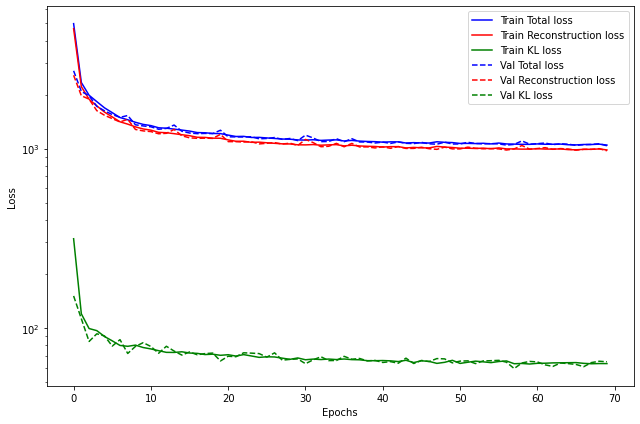

In [15]:
plt.figure(figsize=(9,6))
plt.semilogy(train_loss_log_VAE['loss'], label='Train Total loss', c="b")
plt.semilogy(train_loss_log_VAE['rec'], label='Train Reconstruction loss', c="r")
plt.semilogy(train_loss_log_VAE['kl'], label='Train KL loss', c="green")
plt.semilogy(val_loss_log_VAE['loss'], label='Val Total loss', linestyle="--", c="b")
plt.semilogy(val_loss_log_VAE['rec'], label='Val Reconstruction loss', linestyle="--", c="r")
plt.semilogy(val_loss_log_VAE['kl'], label='Val KL loss', linestyle="--", c="green")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.tight_layout()

## Results

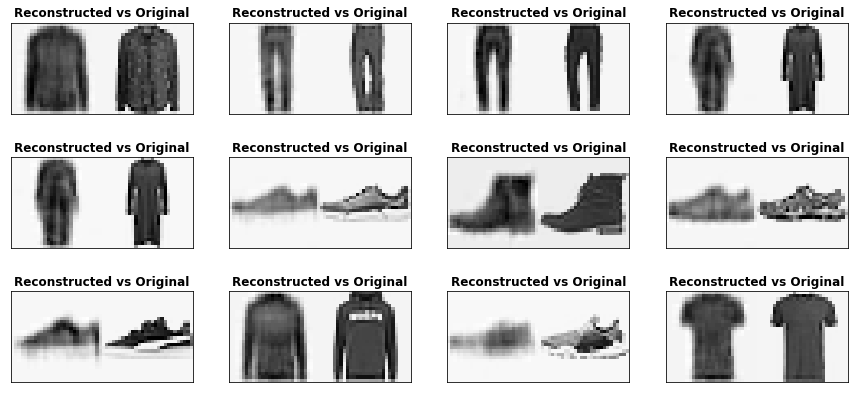

In [16]:
np.random.seed(0)
torch.manual_seed(10)

nsample=np.random.randint(0,100,12)

__, ax = plt.subplots(nrows=3,ncols=4, figsize=(15,7))
with torch.no_grad():
    for i in range(3):
        for j in range(4):
            inp=torch.reshape(test_dataset[nsample[4*i+j]][0],(1,1,28,28)).to(device)
            
            ax[i,j].imshow(np.hstack((myVAE(inp)[0][0][0].detach().cpu(), inp[0][0].detach().cpu())), cmap="Greys")
            ax[i,j].set_title("Reconstructed vs Original", fontweight="bold")

    [axi.set_xticks([]) for axi in ax.flatten()]
    [axi.set_yticks([]) for axi in ax.flatten()]

plt.show()

## Latent Space

In [17]:
nsamples=len(test_dataset)
myVAE.eval()
labels = test_dataset.targets

z_vec, mu_vec, log_var_vec = [], [], []

for i in range(nsamples):
    inp=torch.reshape(test_dataset[i][0],(1,1,28,28)).to(device)
    with torch.no_grad():
        mu, log_var, z = myVAE.latent_space_sample(inp)
    z_vec.append(z.detach().cpu().numpy())
    mu_vec.append(mu.detach().cpu().numpy())
    log_var_vec.append(log_var.detach().cpu().numpy())

z_vae_vec = np.array(z_vec)[:,0,:]
mu_vec = np.array(mu_vec)[:,0,:]
log_var_vec = np.array(log_var_vec)[:,0,:]

### TSNE

In [21]:
np.random.seed(0)
torch.manual_seed(10)

mu_embedded = TSNE(n_components=2, init="pca", learning_rate="auto").fit_transform(log_var_vec)

df_vae = pd.DataFrame(mu_embedded)
df_vae['label'] = labels.long()
df_vae['label_name'] = df_vae.label.apply(lambda l: poss_labels[l])


px.scatter(df_vae, x=0, y=1, color="label_name", width=800, height=600)

### PCA

In [20]:
pca_vae = PCA(2)
mu_vae_pca = pca_vae.fit_transform(log_var_vec)

df_vae_pca = pd.DataFrame(mu_vae_pca)
df_vae_pca['label'] = labels.long()
df_vae_pca['label_name'] = df_vae_pca.label.apply(lambda l: poss_labels[l])

px.scatter(df_vae_pca, x=0, y=1, color="label_name", width=800, height=600)

## Generation of original samples

In [15]:
min_z = np.min(z_vae_vec,axis=0)
max_z = np.max(z_vae_vec,axis=0)

min_max_df = pd.DataFrame({"min":min_z, "max":max_z})

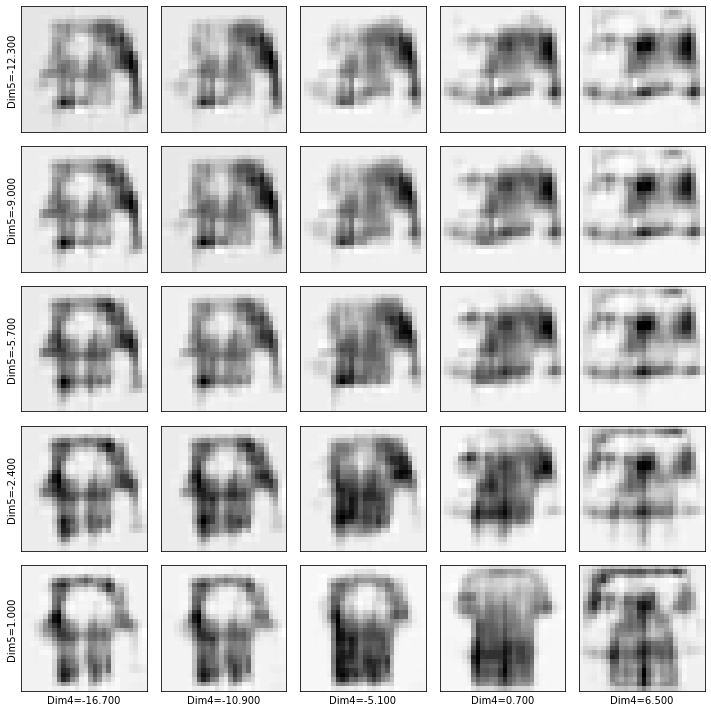

In [18]:
np.random.seed(1)
torch.manual_seed(10)

index=np.random.randint(len(test_dataset))
inp=torch.reshape(test_dataset[index][0],(1,1,28,28)).to(device)
new_z = myVAE.latent_space_sample(inp)[1]
dim_lat1 = 5
dim_lat2 = 4
range1 = np.round(np.linspace(min_max_df.iloc[dim_lat1]["min"]-5,min_max_df.iloc[dim_lat1]["max"]+5,5),1)
range2 = np.round(np.linspace(min_max_df.iloc[dim_lat2]["min"]-10,min_max_df.iloc[dim_lat2]["max"]+10,5),1)


__, ax = plt.subplots(5,5,figsize=(10,10))
#ax=ax.flatten()
for i in range(5):
    new_z[0,dim_lat1]=range1[i]
    for j in range(5):
        new_z[0,dim_lat2]=range2[j]
        with torch.no_grad():
            new_samp = myVAE.generate_new_sample(new_z)
        #ax[i][j].set_title(f"Dim1: {range1[i]}, Dim2:{range2[j]}")
        ax[i][j].imshow(new_samp.detach().cpu().numpy()[0,0,:,:], cmap="Greys")
        ax[i][j].set_xticks([])
        ax[i][j].set_yticks([])

[ax[j][0].set_ylabel("Dim%d=%.3f" %(dim_lat1,range1[j])) for j in range(5)]
[ax[-1][j].set_xlabel("Dim%d=%.3f" %(dim_lat2,range2[j])) for j in range(5)]
plt.tight_layout()
plt.show()

## 2D latent space

### Definition and training

In [51]:
np.random.seed(0)
torch.manual_seed(10)

myVAE_2D, train_loss_log_VAE_2D, val_loss_log_VAE_2D = VAEtraining(num_epochs=50,
                                                         beta=1,
                                                         latent_dim=2,
                                                         optim_name="Adam",
                                                         lr=1e-2,
                                                         w_d=0,
                                                         nonlin="relu",
                                                         #checkpoint="finetuned_2DVAE.pth",
                                                         #printt=True
                                                         )

100%|██████████| 50/50 [04:43<00:00,  5.67s/it]


In [52]:
torch.save(myVAE_2D.state_dict(), "finetuned_2DVAE.pth")

### Results

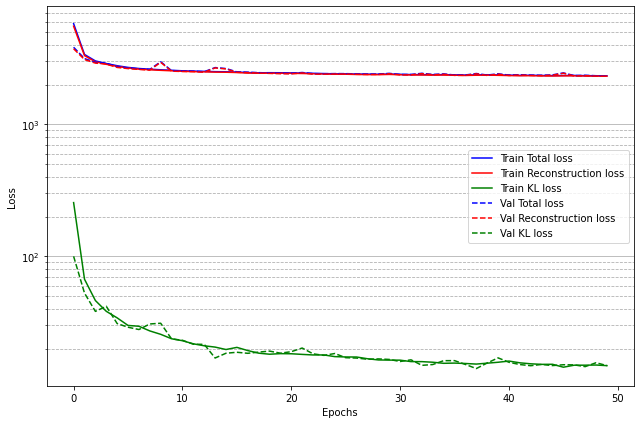

In [53]:
plt.figure(figsize=(9,6))
plt.semilogy(train_loss_log_VAE_2D['loss'], label='Train Total loss', c="b")
plt.semilogy(train_loss_log_VAE_2D['rec'], label='Train Reconstruction loss', c="r")
plt.semilogy(train_loss_log_VAE_2D['kl'], label='Train KL loss', c="green")
plt.semilogy(val_loss_log_VAE_2D['loss'], label='Val Total loss', linestyle="--", c="b")
plt.semilogy(val_loss_log_VAE_2D['rec'], label='Val Reconstruction loss', linestyle="--", c="r")
plt.semilogy(val_loss_log_VAE_2D['kl'], label='Val KL loss', linestyle="--", c="green")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid(axis="y", which="minor", linestyle="--")
plt.grid(axis="y", which="major")
plt.tight_layout()

In [54]:
np.random.seed(0)
torch.manual_seed(10)

nsamples=len(test_dataset)
myVAE_2D.eval()
labels = test_dataset.targets

z_vec_2D, mu_vec_2D, log_var_vec_2D = [], [], []

for i in range(nsamples):
    inp=torch.reshape(test_dataset[i][0],(1,1,28,28)).to(device)
    with torch.no_grad():
        mu, log_var, z = myVAE_2D.latent_space_sample(inp)
    z_vec_2D.append(z.detach().cpu().numpy())
    mu_vec_2D.append(mu.detach().cpu().numpy())
    log_var_vec_2D.append(log_var.detach().cpu().numpy())

z_vae_vec_2D = np.array(z_vec_2D)[:,0,:]
mu_vec_2D = np.array(mu_vec_2D)[:,0,:]
log_var_vec_2D = np.array(log_var_vec_2D)[:,0,:]

df_vae_2D = pd.DataFrame(mu_vec_2D)
df_vae_2D['label'] = labels.long()
df_vae_2D['label_name'] = df_vae_2D.label.apply(lambda l: poss_labels[l])

In [55]:
px.scatter(df_vae_2D, x=0, y=1, color="label_name", width=800, height=600)

### Original samples

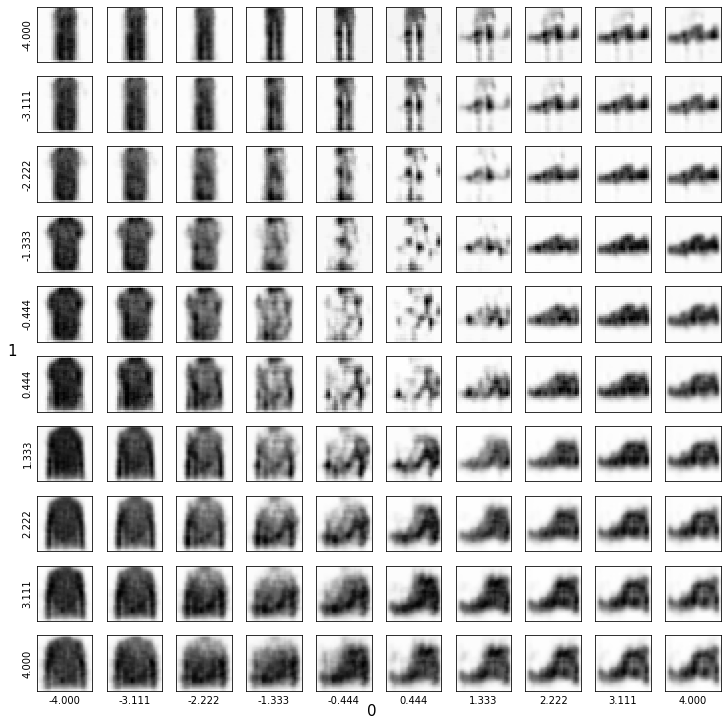

In [56]:
np.random.seed(0)
torch.manual_seed(10)

x_vae_1=np.linspace(-4,4,10)
x_vae_2=np.linspace(-4,4,10)


__, ax_vae_2D=plt.subplots(len(x_vae_1),len(x_vae_2),figsize=(10,10))
for i,x1 in enumerate(x_vae_1):
    for j,x2 in enumerate(x_vae_2):
        new_z_2D=torch.Tensor([x1,x2]).unsqueeze(0).to(device)
        ax_vae_2D[i,j].imshow(myVAE_2D.generate_new_sample(new_z_2D).detach().cpu().numpy()[0,0], cmap="Greys")
[axx.set_xticks([]) for axx in ax_vae_2D.flatten()]
[axx.set_yticks([]) for axx in ax_vae_2D.flatten()]

[ax_vae_2D[j][0].set_ylabel("%.3f" %(x_vae_1[j])) for j in range(len(x_vae_1))]
[ax_vae_2D[-1][j].set_xlabel("%.3f" %(x_vae_2[j])) for j in range(len(x_vae_2))]

__.text(0.5, 0, '0', ha='center', fontsize=15)
__.text(0, 0.5, '1', ha='center', fontsize=15)

plt.tight_layout()
plt.show()

## $\beta$ VAE

In [14]:
np.random.seed(0)
torch.manual_seed(10)

df_beta = []
df_sigma_beta = []
bVAE_models=[]

beta_vec=[1,10,50,100,250,500]

for beta in beta_vec:
    print(f"Training for beta = {beta}")
    myBVAE_2D, train_loss_log_BVAE_2D, val_loss_log_BVAE_2D = VAEtraining(num_epochs=50,
                                                            beta=beta,
                                                            latent_dim=20,
                                                            optim_name="Adam",
                                                            lr=1e-2,
                                                            w_d=0,
                                                            nonlin="relu",
                                                            #checkpoint="finetuned_VAE.pth",
                                                            #printt=True
                                                            )

    bVAE_models.append(myBVAE_2D)

Training for beta = 1


100%|██████████| 50/50 [05:28<00:00,  6.57s/it]


Training for beta = 10


100%|██████████| 50/50 [05:13<00:00,  6.27s/it]


Training for beta = 50


100%|██████████| 50/50 [05:15<00:00,  6.31s/it]


Training for beta = 100


100%|██████████| 50/50 [05:08<00:00,  6.17s/it]


Training for beta = 250


100%|██████████| 50/50 [05:19<00:00,  6.38s/it]


Training for beta = 500


100%|██████████| 50/50 [06:25<00:00,  7.70s/it]


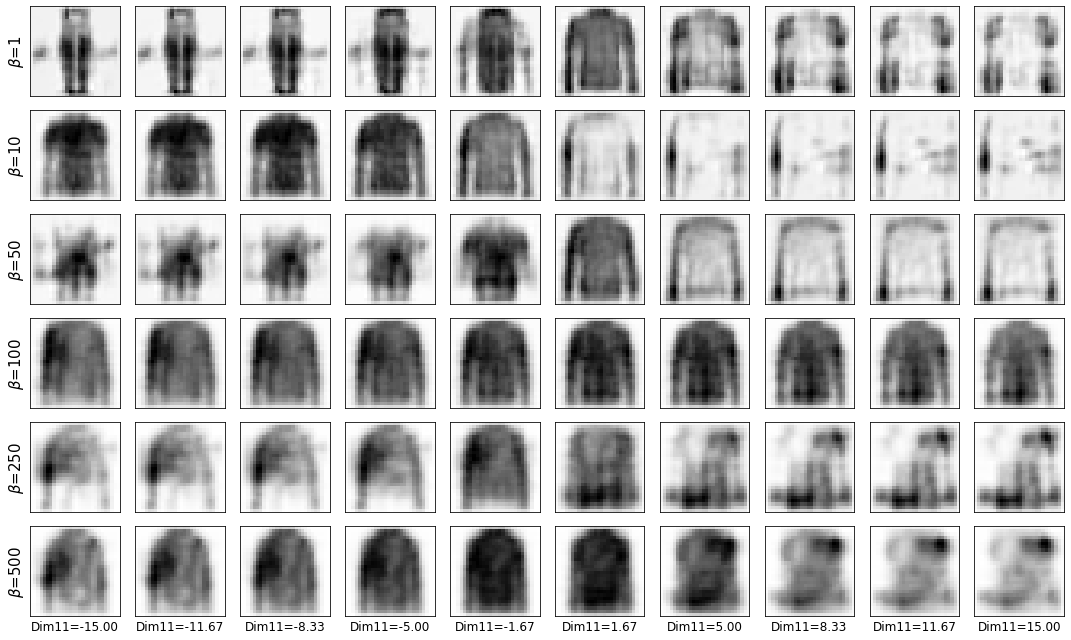

In [41]:
np.random.seed(2)
torch.manual_seed(10)

index=50
inp=torch.reshape(test_dataset[index][0],(1,1,28,28)).to(device)


dim_lat = 11
range1 = np.linspace(-15,15,10)

__, ax = plt.subplots(len(beta_vec),10,figsize=(15,9))

for i in range(len(beta_vec)):
    new_z = bVAE_models[i].latent_space_sample(inp)[1]
    for j in range(10):
        new_z[0,dim_lat]=range1[j]
        with torch.no_grad():
            new_samp = bVAE_models[i].generate_new_sample(new_z)

        ax[i][j].imshow(new_samp.detach().cpu().numpy()[0,0,:,:], cmap="Greys")
        ax[i][j].set_xticks([])
        ax[i][j].set_yticks([])

[ax[-1][i].set_xlabel("Dim%d=%.2f" %(dim_lat,range1[i]), fontsize=12) for i in range(10)]
[ax[j][0].set_ylabel(r"$\beta$=%d" %(beta_vec[j]), fontsize=15) for j in range(len(beta_vec))]
plt.tight_layout()
plt.show()

# GANS

In [16]:
# Nr of color channels
nc=1

# Size of random vector from which the fake images are generated
nz = 20

# Size of feature maps in generator
ngf = 28

# Size of feature maps in discriminator
ndf = 28

## Generator

In [17]:
# Generator Code

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            nn.ConvTranspose2d(in_channels = nz, out_channels = ngf * 8, kernel_size = 7, stride = 1, padding = 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            nn.ConvTranspose2d( ngf * 4, nc, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, input):
        return self.main(input)

In [18]:
netG = Generator()
netG.to(device)

print(netG)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(20, 224, kernel_size=(7, 7), stride=(1, 1), bias=False)
    (1): BatchNorm2d(224, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(224, 112, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(112, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(112, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): Tanh()
  )
)


## Discriminator

In [24]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.ReLU(),
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.ReLU(),
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.ReLU(),
            nn.Conv2d(ndf * 4, 1, 3, 2, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

In [25]:
netD = Discriminator()
netD.to(device)

#netD.apply(weights_init)

print(netD)

Discriminator(
  (main): Sequential(
    (0): Conv2d(1, 28, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): ReLU()
    (2): Conv2d(28, 56, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(56, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): ReLU()
    (5): Conv2d(56, 112, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(112, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): ReLU()
    (8): Conv2d(112, 1, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (9): Sigmoid()
  )
)


## Training

In [34]:
np.random.seed(2)
torch.manual_seed(10)

# Learning rate for optimizers
lr = 0.001

# Initialize BCELoss function
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr)
optimizerG = optim.Adam(netG.parameters(), lr=lr)


In [35]:
np.random.seed(2)
torch.manual_seed(10)

# Training Loop
num_epochs = 300

# Lists to keep track of progress
img_list = []
G_loss = []
D_loss = []
iters = 0

print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    G_losses = []
    D_losses = []
    for i, data in enumerate(train_dataloader, 0):

        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        netD.zero_grad()
        # Format batch
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        # Forward pass real batch through D
        output = netD(real_cpu).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        # Generate fake image batch with G
        fake = netG(noise)
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = netD(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch, accumulated (summed) with previous gradients
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Compute error of D as sum over the fake and the real batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        with torch.no_grad():
            fake = netG(fixed_noise).detach().cpu()
        img_list.append(fake.detach().cpu().numpy())

        iters += 1

    G_loss.append(np.mean(G_losses))
    D_loss.append(np.mean(D_losses))

        # Output training stats
    print('[%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f' 
            % (epoch, num_epochs, D_loss[-1], G_loss[-1], D_x, D_G_z1, D_G_z2))




Starting Training Loop...
[0/300]	Loss_D: 0.0850	Loss_G: 5.4373	D(x): 0.9917	D(G(z)): 0.0300 / 0.0190
[1/300]	Loss_D: 0.0514	Loss_G: 6.0500	D(x): 0.9837	D(G(z)): 0.0193 / 0.0078
[2/300]	Loss_D: 0.0444	Loss_G: 6.2520	D(x): 0.9914	D(G(z)): 0.0056 / 0.0038
[3/300]	Loss_D: 0.0461	Loss_G: 6.0838	D(x): 0.9757	D(G(z)): 0.0198 / 0.0042
[4/300]	Loss_D: 0.0625	Loss_G: 6.4757	D(x): 0.9603	D(G(z)): 0.0151 / 0.0011
[5/300]	Loss_D: 0.0670	Loss_G: 5.9343	D(x): 0.9786	D(G(z)): 0.0085 / 0.0031
[6/300]	Loss_D: 0.0627	Loss_G: 6.1558	D(x): 0.9939	D(G(z)): 0.0125 / 0.0057
[7/300]	Loss_D: 0.0513	Loss_G: 5.9155	D(x): 0.9955	D(G(z)): 0.0187 / 0.0112
[8/300]	Loss_D: 0.0504	Loss_G: 5.9590	D(x): 0.9829	D(G(z)): 0.0332 / 0.0176
[9/300]	Loss_D: 0.1937	Loss_G: 6.0860	D(x): 0.9757	D(G(z)): 0.0204 / 0.0142
[10/300]	Loss_D: 0.0617	Loss_G: 5.7459	D(x): 0.9842	D(G(z)): 0.0175 / 0.0094
[11/300]	Loss_D: 0.0609	Loss_G: 5.4496	D(x): 0.9822	D(G(z)): 0.0304 / 0.0115
[12/300]	Loss_D: 0.0641	Loss_G: 5.5728	D(x): 0.9952	D(G(z)):

## Loss

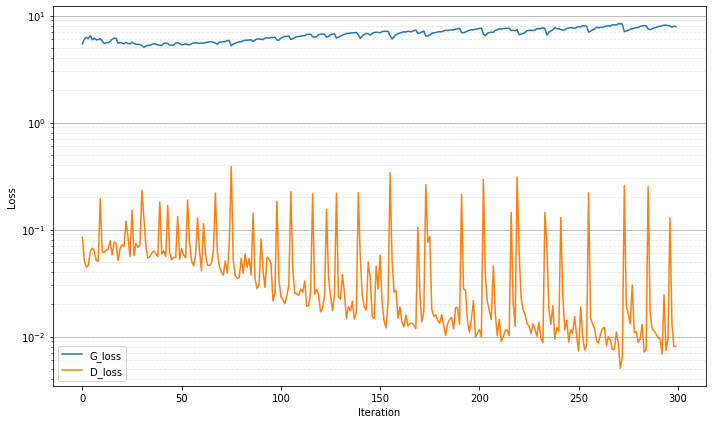

In [83]:
plt.figure(figsize=(10,6))

plt.semilogy(G_loss, label='G_loss')
plt.semilogy(D_loss, label='D_loss')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.legend()

plt.grid(which="minor", linestyle="--", axis="y", alpha=0.3)
plt.grid(which="major", linestyle="-", axis="y")

plt.tight_layout()

## Results

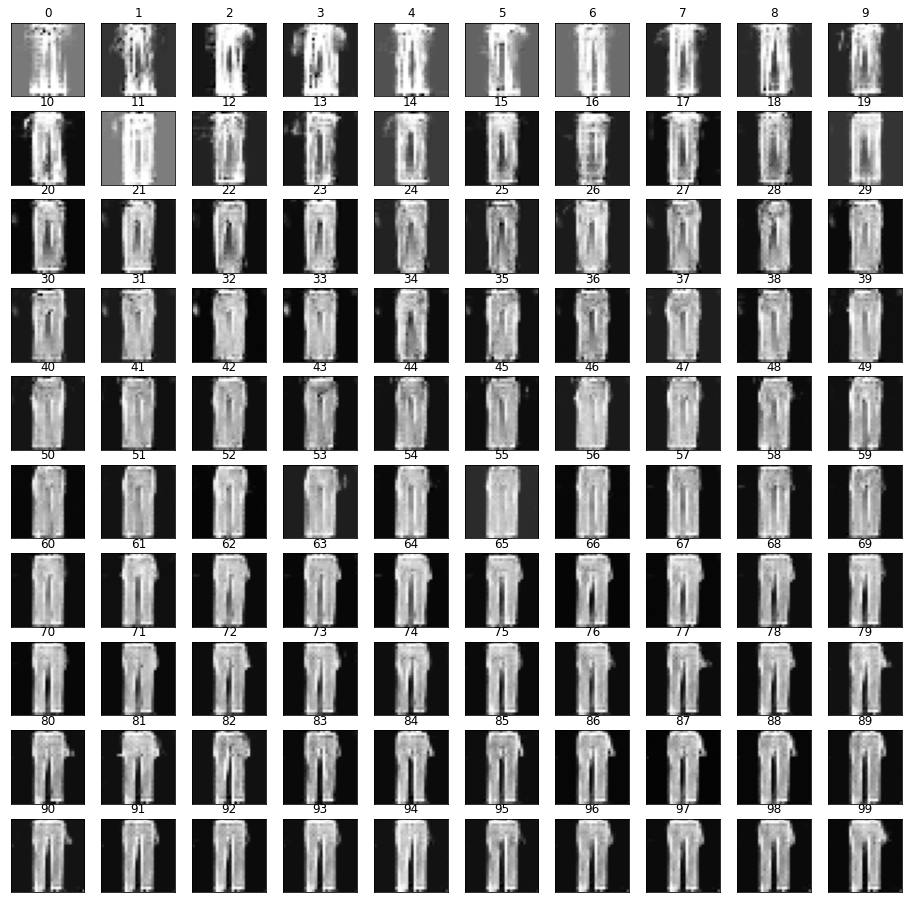

In [84]:
sample_num = 55

__, ax = plt.subplots(10,10,figsize=(16,16))
ax=ax.flatten()
for i in range(100):
    ax[i].imshow(img_list[i][sample_num][0],cmap="gray")
    ax[i].set_title(f"{i}")
    ax[i].set_xticks([])
    ax[i].set_yticks([])
plt.show()

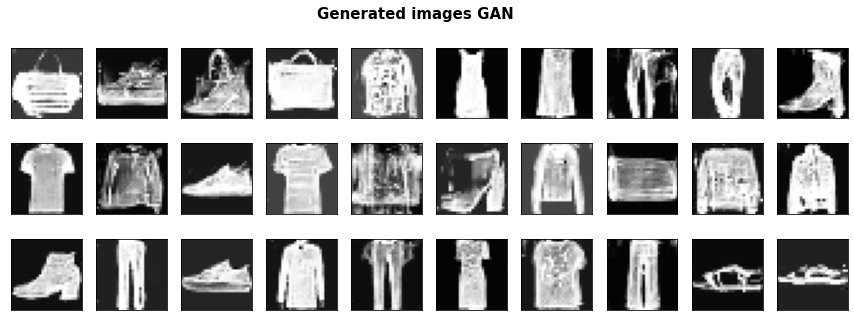

In [62]:
samples=np.random.randint(0,64,30)

__, axex = plt.subplots(3, int(len(samples)/3), figsize=(15,5))
axex=axex.flatten()

for i in range(len(samples)):
    axex[i].imshow(img_list[-1][i][0], cmap="gray")


[ax.set_xticks([]) for ax in axex]
[ax.set_yticks([]) for ax in axex]
plt.suptitle("Generated images GAN", fontweight="bold", fontsize=15)
plt.show()

### GIF Generation

In [85]:
nsamp=55
img_list=np.array(img_list)


plt.close()

niter=300

for i in range(niter):
    plt.title(f"Iter {i}")
    plt.imshow(np.array(img_list)[i][nsamp][0], cmap="gray")
    plt.xticks([])
    plt.yticks([])
    plt.savefig(f'GIFimgs/im{i}.png')
    plt.close()

with imageio.get_writer('mygif.gif', mode='I') as writer:
    for i in range(niter):
        image = imageio.imread(f'GIFimgs/im{i}.png')
        writer.append_data(image)